In [1]:
import numpy as np
import pandas as pd

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Fri Aug 16 14:34:39 2019

@author: Chen
"""

class YOLO_Kmeans:
    def __init__(self, cluster_number, filename):
        self.cluster_number = cluster_number
        self.filename = filename
    def iou(self, boxes, clusters):  # 1 box -> k clusters 
        n = boxes.shape[0]
        k = self.cluster_number
        box_area = boxes[:, 0] * boxes[:, 1]
        box_area = box_area.repeat(k)
        box_area = np.reshape(box_area, (n, k))
        cluster_area = clusters[:, 0] * clusters[:, 1]
        cluster_area = np.tile(cluster_area, [1, n])
        cluster_area = np.reshape(cluster_area, (n, k))
        box_w_matrix = np.reshape(boxes[:, 0].repeat(k), (n, k))
        cluster_w_matrix = np.reshape(np.tile(clusters[:, 0], (1, n)), (n, k))
        min_w_matrix = np.minimum(cluster_w_matrix, box_w_matrix)
        box_h_matrix = np.reshape(boxes[:, 1].repeat(k), (n, k))
        cluster_h_matrix = np.reshape(np.tile(clusters[:, 1], (1, n)), (n, k))
        min_h_matrix = np.minimum(cluster_h_matrix, box_h_matrix)
        inter_area = np.multiply(min_w_matrix, min_h_matrix)
# 计算IOU值
        result = inter_area / (box_area + cluster_area - inter_area)
        return result
    def avg_iou(self, boxes, clusters):
        accuracy = np.mean([np.max(self.iou(boxes, clusters), axis=1)])
        return accuracy
    
    def kmeans(self, boxes, k, dist=np.median):
	#聚类问题
        box_number = boxes.shape[0]
        distances = np.empty((box_number, k))
        last_nearest = np.zeros((box_number,))
        np.random.seed()
        clusters = boxes[np.random.choice(
            box_number, k, replace=False)]  # init k clusters
        while True:
            distances = 1 - self.iou(boxes, clusters)  
            current_nearest = np.argmin(distances, axis=1)
            if (last_nearest == current_nearest).all():
                break  # clusters won't change
            for cluster in range(k):
                clusters[cluster] = dist(  # update clusters
                    boxes[current_nearest == cluster], axis=0)
            last_nearest = current_nearest
        return clusters
    
    def result2txt(self, data):
        f = open("yolo_anchors.txt", 'w')
        row = np.shape(data)[0]
        for i in range(row):
            if i == 0:
                x_y = "%d,%d" % (data[i][0], data[i][1])
            else:
                x_y = ", %d,%d" % (data[i][0], data[i][1])
            f.write(x_y)
        f.close()
        
    def txt2boxes(self):
        f = open(self.filename, 'r')
        dataSet = []
        for line in f:
            infos = line.split(" ")
            length = len(infos)
            for i in range(1, length):
                width = int(infos[i].split(",")[2]) - \
                    int(infos[i].split(",")[0])
                height = int(infos[i].split(",")[3]) - \
                    int(infos[i].split(",")[1])
                dataSet.append([width, height])
        result = np.array(dataSet)
        f.close()
        return result
    
    def csv2boxes(self):
        anns_all = pd.read_csv(self.filename)  #读取csv文件。
        nodule = anns_all[anns_all.label == 1]
        return np.array(nodule[['diameterX','diameterY']].values)
        
        
    def txt2clusters(self):
        all_boxes = self.csv2boxes()
        result = self.kmeans(all_boxes, k=self.cluster_number)
        result = result[np.lexsort(result.T[0, None])]
        self.result2txt(result)
        print("K anchors:\n {}".format(result))
        print("Accuracy: {:.2f}%".format(
            self.avg_iou(all_boxes, result) * 100))
        
if __name__ == "__main__":
    cluster_number = 36
    filename = "../dataset/trans_annotation.csv"
    kmeans = YOLO_Kmeans(cluster_number, filename)
    kmeans.txt2clusters()

D:\anaconda\lib\site-packages\numpy\core\fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
D:\anaconda\lib\site-packages\numpy\core\_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


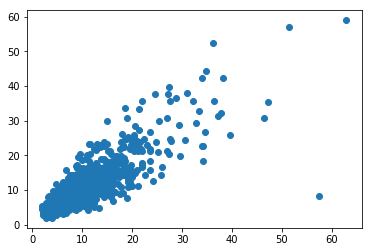

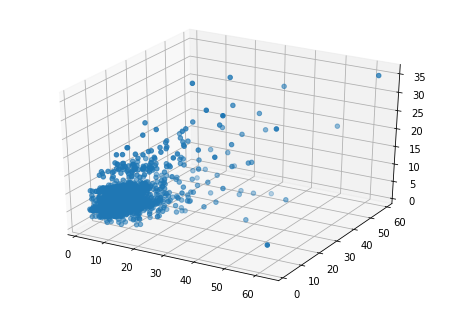

In [7]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
%matplotlib inline

filename = "../dataset/chestCT_round1_annotation.csv"
anns_all = pd.read_csv(filename)
nodule = anns_all[anns_all.label == 1]

#print(nodule[['diameterX','diameterY']].values)

#print(nodule['diameterZ'])

plt.scatter(nodule[['diameterX']].values,nodule[['diameterY']].values)
fig = plt.figure(2)
ax = Axes3D(fig) 
ax.scatter(nodule[['diameterX']].values,nodule[['diameterY']].values,nodule[['diameterZ']].values) 



In [107]:

"""
Created on Fri Aug 16 11:21:53 2019

保存为csv

@author: Chen
"""
import os
import numpy as np
import pandas as pd
import re
import SimpleITK as sitk
import glob



def load_itk(file_name, file_path):
    '''
    modified from https://stackoverflow.com/questions/37290631/reading-mhd-raw-format-in-python
    '''
    
    # Reads the image using SimpleITK
    file = os.path.join(file_path, file_name + '.mhd')
    itkimage = sitk.ReadImage(file)

    # Convert the image to a  numpy array first and then shuffle the dimensions to get axis in the order z,y,x
    ct_scan = sitk.GetArrayFromImage(itkimage)

    # Read the origin of the ct_scan, will be used to convert the coordinates from world to voxel and vice versa.  
    origin = np.array(list(reversed(itkimage.GetOrigin())))

    # Read the spacing along each dimension   (z,y,x)
    spacing = np.array(list(reversed(itkimage.GetSpacing())))

    return ct_scan, origin, spacing

def get_csv(anns_all, file_path, ):
    '''
    get mask and save
    '''

    '''
    input:
    seriesuid: specify the scan plotted.
    anns_all:  the annotation provided (Dataframe).
    file_path: the path of the data.
    plot_path: the path of the visualization, default: make a subdirectory under the current dir.   
    clip_min:  the lower boundary which is used for clipping the CT valued for the lung window.
    clip_max:  the upper boundary which is used for clipping the CT valued for the lung window.
    only_df:   if True, only return the dataframe , and do not plot.
    return_ct: if True, return the dataframe with the ct array.
    
    return:
    ann_df:    return the annotation dataframe according to the seriesuid
    
    Mediastinum window: clipmin=-150, clipmax=250
    '''
    

    id_list = []
    for file in glob.glob(file_path+'*.mhd'):
        uid = re.findall(re.compile(r'\d+'),file)[0]
        id_list.append(uid)
        
        
    result = pd.DataFrame(columns = anns_all.columns)
    for index,seriesuid in enumerate(id_list):
        ann_df = anns_all.query('seriesuid == "%s"' % seriesuid).copy()    
        if not ann_df.empty:
            ct, origin, spacing = load_itk(file_name=seriesuid, file_path=file_path)
            # coordinate transform: world to voxel
            ann_df.coordX = (ann_df.coordX - origin[2]) / spacing[2]
            ann_df.coordY = (ann_df.coordY - origin[1]) / spacing[1]
            ann_df.coordZ = (ann_df.coordZ - origin[0]) / spacing[0]
            ann_df.diameterX = ann_df.diameterX / spacing[2]
            ann_df.diameterY = ann_df.diameterY / spacing[1]
            ann_df.diameterZ = ann_df.diameterZ / spacing[0] 
        
        #print(pd.concat([result, ann_df]))
        #print('=================')
        result = pd.concat([result, ann_df])
        #print(result)
        del ann_df
        
    #print(result)
    return result

    
file_path = '../dataset//trainset/'
test_file_path = '../dataset//testA/'
anns_path = '../dataset//chestCT_round1_annotation.csv'
anns_all = pd.read_csv(anns_path)  #读取csv文件。

v = get_csv(anns_all, file_path,)
v.to_csv('trans_annotation.csv')